# Modelling notebook 4: Multi-layer Perceptron

In this notebook, we build Multi-layer Perceptron models for predicting fog. The data is split into a trian/validation set to make modelling decisions, and an unseen test set for checking the generalisation error of the models.
<br>

**Train:** 2011-2017
**Validation:** 2018-2019 
**Test:** 2020 and 2021

Contents:


## 1. Import Packages & Data

In [ ]:
!pip uninstall scikit-learn -y
!pip install scikit-learn==1.2.1
!pip install -U neptune-client==0.16.18
!pip install -U neptune-sklearn==2.0.0
!pip install scikit-optimize==0.9.0

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 20.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.8/448.8 KB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 KB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.7/134.7 KB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 11.2 MB/s et

In [ ]:
import sklearn
print(sklearn.__version__)

1.2.1


In [ ]:
# data processing
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from scipy import stats

# modelling
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, \
RandomizedSearchCV, train_test_split, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from scipy.stats import uniform, randint

from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
from skopt import BayesSearchCV, gp_minimize

import neptune.new as neptune
import neptune.new.integrations.sklearn as npt_utils

# visualisations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# other

from tqdm import tqdm
import pickle
import os
import sys
seed=42

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importing data and helper functions from directories dependent on which is available

joseph_path = '/content/drive/My Drive/DS_Modules/CA4021 (Final Year Project)/' # Joseph
julita_path = '/content/drive/My Drive/CA4021 (Final Year Project)/' # Julita

if os.path.exists(joseph_path):
  print("Importing from DS_Modules/CA4021")
  sys.path.append(os.path.join(joseph_path, 'scripts'))
  path = joseph_path

elif os.path.exists(julita_path):
  print("Importing directly from CA4021 folder")
  sys.path.append(sys.path.append(os.path.join(julita_path, 'scripts')))
  path = julita_path

Importing from DS_Modules/CA4021


In [ ]:
# import helper functions from aux files (prevents too much function definitions in the notebook)
from aux_functions import missing_percentages, plot_dist_discrete, plot_dist_continuous, \
plot_vis_discrete, plot_vis_continuous, month_vplot

from aux_functions_ml import preprocess, manual_cross_validate, get_feat_importance_df, \
performance_report, calc_mean_importance, plot_importance, heidke_skill_score, score_model, display_scores

In [ ]:
# import train/valid and test sets
df_train = pd.read_csv(os.path.join(path, 'data/train_data.csv'))
df_train.index=pd.to_datetime(df_train.date_time)
df_train.date_time = df_train.index

df_test = pd.read_csv(os.path.join(path, 'data/test_data.csv'))
df_test.index=pd.to_datetime(df_test.date_time)
df_test.date_time = df_test.index

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

print("Train/valid:", df_train.shape)
print("Test:", df_test.shape)

Train/valid: (78888, 57)
Test: (17544, 57)


In [ ]:
df_train.head()

,date_time,year,month,day,hour,date,dir,speed,vis,ww,w,pchar,ptend,cbl,msl,drybulb,wetbulb,dewpt,vp,rh,clow,cmedium,chigh,nlc,ntot,hlc,nsig1,tsig1,hsig1,nsig2,tsig2,hsig2,nsig3,tsig3,hsig3,nsig4,tsig4,hsig4,ceiling,dos,weather,duration,rainfall,sunshine,tabdir,tabspeed,pweather,dni,vis_hr1,target_hr1,fog_state,season,temp_dew_dist,rainfall12hma,fog_formation,fog_dissipation,transition
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,2011,1,1,0,01-Jan-2011 00:00:00,27,7,9000,10,22,5,0.1,1017.1,1027.8,5.5,4.6,3.3,7.8,86,5.0,0.0,0.0,7,7,22,7,6,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22,0.0,0,0.0,0.0,0.0,26,6,0,0,9000.0,0,no fog,winter,2.2,0.0,0,0,0
2011-01-01 01:00:00,2011-01-01 01:00:00,2011,1,1,1,01-Jan-2011 01:00:00,28,6,9000,10,22,5,0.0,1017.1,1027.8,5.1,4.4,3.4,7.8,89,5.0,0.0,0.0,7,7,22,7,6,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22,0.0,0,0.0,0.0,0.0,28,6,0,0,8000.0,0,no fog,winter,1.7,0.0,0,0,0
2011-01-01 02:00:00,2011-01-01 02:00:00,2011,1,1,2,01-Jan-2011 02:00:00,27,6,8000,10,22,8,0.2,1016.8,1027.5,5.3,4.0,2.1,7.1,80,5.0,0.0,0.0,7,7,22,7,6,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22,0.0,0,0.0,0.0,0.0,27,7,0,0,8000.0,0,no fog,winter,3.2,0.0,0,0,0
2011-01-01 03:00:00,2011-01-01 03:00:00,2011,1,1,3,01-Jan-2011 03:00:00,25,7,8000,10,22,7,0.5,1016.6,1027.3,5.2,4.6,3.7,8.0,90,5.0,0.0,0.0,7,7,23,7,6,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23,0.0,0,0.0,0.0,0.0,27,7,0,0,8000.0,0,no fog,winter,1.5,0.0,0,0,0
2011-01-01 04:00:00,2011-01-01 04:00:00,2011,1,1,4,01-Jan-2011 04:00:00,28,7,8000,10,22,6,0.5,1016.6,1027.3,5.1,4.7,4.1,8.2,94,5.0,0.0,0.0,7,7,24,7,6,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24,0.0,0,0.0,0.0,0.0,27,7,0,0,9000.0,0,no fog,winter,1.0,0.0,0,0,0


In [ ]:
# LEAVING OUT w, ww, pweather and weather because of OH encoding sparsity

metadata = ['date', 'date_time', 'year', 'month', 'day', 'hour', 'season']
indicator = [col for col in df_train.columns if col[0] == 'i']
constant = [var for var in df_train.columns if len(df_train[var].value_counts()) == 1]
codes = ['sp1', 'sp2', 'sp3', 'sp4', 'wwa', 'wa', 'w' ,'ww', 'pweather', 'weather']
excluded = indicator + constant + codes + ['rgauge', 'sog', 'tabspeed', 'msl']
vis_vars=['target_hr1', 'vis_hr1', 'fog_formation', 'fog_dissipation', 'transition']
target = 'target_hr1'

categorical=['fog_state', 'season', 'tsig1', 'tsig2', 'tsig3', 'pchar'] #'w', 'ww', 'pweather',
             #'weather']
discrete = [var for var in df_train.columns if len(df_train[var].unique()) < 15 and 
             var not in excluded + categorical + metadata + codes + indicator + vis_vars]

continuous = [var for var in df_train.columns if var not in discrete + excluded + categorical + metadata + codes + indicator + vis_vars]
numerical = discrete+continuous
# conservative list of variables known to have an impact on fog formation.
# the other lists are too big for certain visualisations
fog_vars = ['rainfall', 'drybulb', 'cbl', 'ntot', 'dni', 'dewpt', 'speed', 'dir', 'rh']

In [ ]:
# selected variables from XGBoost notebook
vars_sel = ['vis', 'temp_dew_dist', 'rh', 'ceiling', 'duration', 'hsig2', 'dni', 
                  'dewpt', 'drybulb', 'cbl', 'hlc', 'ntot', 'speed', 'vp', 'pchar','dir']
num_vars_sel = [var for var in vars_sel if var in discrete+continuous]
cat_vars_sel = [var for var in vars_sel if var in categorical]

In [ ]:
dates = df_train.date_time
X = df_train[numerical + categorical + vis_vars].reset_index(drop=True)
y = X.pop(target)

In [ ]:
all(y == df_train[target].values)

True

In [ ]:
model = MLPClassifier(hidden_layer_sizes=(128, 64), 
                      activation='relu', 
                      solver='adam', 
                      early_stopping=True, 
                      n_iter_no_change=50,
                      random_state=seed)

Fold : 1
training size: (13148, 73)
test size: (13148, 73)
[[13020    16]
 [   72    40]]
****************************************************************************************************
Fold : 2
training size: (26296, 76)
test size: (13148, 76)
[[12946    41]
 [   62    99]]
****************************************************************************************************
Fold : 3
training size: (39444, 77)
test size: (13148, 77)
[[13029    24]
 [   40    55]]
****************************************************************************************************
Fold : 4
training size: (52592, 77)
test size: (13148, 77)
[[13037    22]
 [   54    35]]
****************************************************************************************************
Fold : 5
training size: (65740, 78)
test size: (13148, 78)
[[13078    15]
 [   31    24]]
****************************************************************************************************


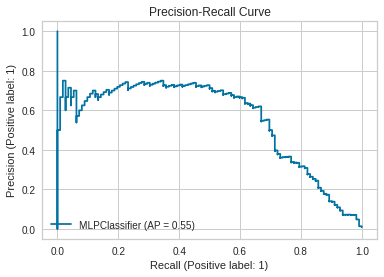

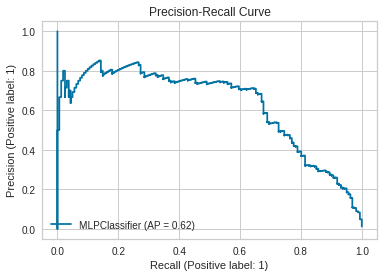

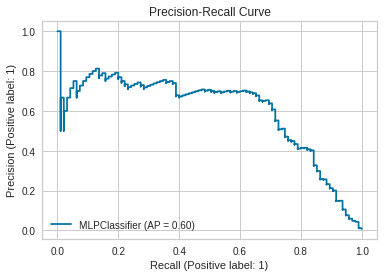

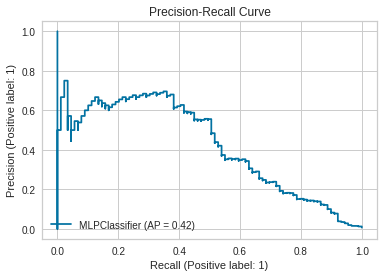

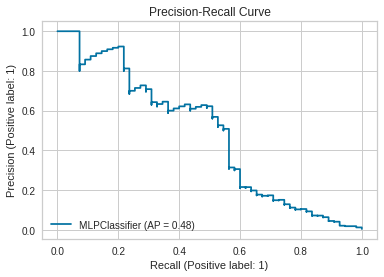

In [ ]:
full_model_scores, gain_importance_tables, _ = manual_cross_validate(model, X, y, 
                                                                     cat_vars=categorical, 
                                                                     num_vars=numerical, 
                                                                     folds=5,
                                                                     cat_encoder='oh',
                                                                     calc_feature_importance=False)


In [ ]:
performance_report(full_model_scores)

Validation Scores
------------------------------
f1_score
Scores: [39.74, 60.69, 58.02, 46.81, 48.84]
Mean: 50.820

heidke_skill_score
Scores: [0.3947, 0.6026, 0.5777, 0.4654, 0.4868]
Mean: 0.505

transition_f1_score
Scores: [14.63, 30.95, 20.93, 23.91, 20.0]
Mean: 22.084

transition_hss_score
Scores: [-0.0472, -0.1493, -0.2308, -0.1363, -0.1272]
Mean: -0.138

pr_auc
Scores: [0.5449, 0.5652, 0.5873, 0.3777, 0.4842]
Mean: 0.512



## Hyperparameter Tuning

Experimenting with different methods (Randomized Search CV and Bayesian Optimisation)

The bayesian optimisation was moved to a GCP VM as it was taking too long to run in google colab. The results are imported here.

skpot parameter tuning support tuple arguements, which is present in the MLPClassifier's hidden_layer_sizes argument. Due to this we could only build neural nets with the same number of neurons in each layer within the bayesian optimisation. 

In [ ]:
# creating training sets using only the selected features
X_train, X_test = preprocess(df_train, df_test, cat_vars=cat_vars_sel, num_vars=num_vars_sel, cat_encoder='oh')
# create training data using all the variables df_train (for comparison)
X_train_all, X_test_all = preprocess(df_train, df_test, 
                                     cat_vars=categorical, num_vars=continuous+discrete, cat_encoder='oh')
y_train = y.copy()
y_test = df_test[target]

In [ ]:
# for compatibility with TimeSeriesSplit
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [ ]:
# Randomised Search optimisation - previously fitted and saved to file
params = {'hidden_layer_sizes': [(256), (128,), (64,), (32,),   
                                 (256, 64), (256, 32), (128, 64), (128, 32), (64, 32),
                                 (256, 128, 64), (128, 64, 32)],  # default (100)
          'n_iter_no_change': [10, 50, 100, 250],  # default 10
          'batch_size': [100, 200, 500, 1000],  # default 200
          'max_iter': [100, 200, 500, 1000],  # epochs, default 200
          
          # fixed params:
          'early_stopping': [True],
          'solver': ['adam'],
          'activation':['relu'],
          'random_state': [seed]
          }   

mlp_model = MLPClassifier(random_state=seed, 
                          early_stopping=True, 
                          solver='adam', 
                          activation='relu')
time_split = TimeSeriesSplit(n_splits = 5)
mlp_search_random = RandomizedSearchCV(mlp_model,param_distributions=params, random_state=seed, n_iter=25, cv=time_split, verbose=2, n_jobs=1, return_train_score=True)

In [ ]:
# Bayesian optimisation - This was run in a script separately
space = list()

space.append(Integer(10, 100, prior='log-uniform', name='n_iter_no_change'))  # default 10
space.append(Integer(100, 500, prior='uniform', name='max_iter'))  # epochs, default 200
space.append(Integer(100, 1000, prior='uniform', name='batch_size'))  # default 200
space.append(Categorical(['relu', 'logistic'], name='activation'))
space.append(Real(1e-6, 50, prior='log-uniform', name='alpha'))  # default 0.0001

# skopt can't handle search spaces of tuples, so we pass in n_layers and n_neurons separately
# and build these into the objective function manually
space.append(Integer(1, 2, name='n_hidden_layers'))
space.append(Integer(100, 1000, name='n_neurons_per_layer'))

model = MLPClassifier(solver='adam', 
                      random_state=seed, 
                      early_stopping=True)

@use_named_args(space)
def objective(**params):
  n_neurons = params['n_neurons_per_layer']
  n_layers = params['n_hidden_layers']

  # create hidden layers as a tuple with lenth n_layers and n_neurons per layer
  params['hidden_layer_sizes'] = (n_neurons,)*n_layers
  params.pop('n_neurons_per_layer')
  params.pop('n_hidden_layers')

  model.set_params(**params)
  time_split = TimeSeriesSplit(n_splits = 5)

  # minimizing negative f1 is maximising f1
  return -np.mean(cross_val_score(model, X_train, y_train, cv=time_split,
                                  scoring='f1'))

In [ ]:
# load random hyperparameter search
with open(os.path.join(path, 'results/mlp_hyperparam_search_random.pickle'), 'rb') as file:
  mlp_search_random = pickle.load(file)

best_random_params = mlp_search_random.best_params_

In [ ]:
# load bayesian search - from neptune
param_names = ['n_iter_no_change', 'max_iter', 'batch_size', 'activation', 'alpha']
bayes_search = [100, 500, 100, 'logistic', 1e-06, 2, 762]
bayes_params = {}
for k, v in zip(param_names, bayes_search):
  bayes_params[k] = v

bayes_params['hidden_layer_sizes'] = (762, 762)
bayes_params['early_stopping'] = True
bayes_params['solver'] = 'adam'
bayes_params['random_state'] = seed
bayes_params

{'n_iter_no_change': 100,
 'max_iter': 500,
 'batch_size': 100,
 'activation': 'logistic',
 'alpha': 1e-06,
 'hidden_layer_sizes': (762, 762),
 'early_stopping': True,
 'solver': 'adam',
 'random_state': 42}

In [ ]:
# Unable to train this here. Most likely due to the hidden layer sizes
#bayes_validation_model = mlp_model = MLPClassifier(**bayes_params)
#bayes_validation_model_scores, _, _ = manual_cross_validate(model=bayes_validation_model, 
#                                                 X=X, y=y,
#                                                 num_vars=num_vars_sel,
#                                                 cat_vars=cat_vars_sel,              
#                                                 folds=5,
#                                                 cat_encoder='oh',
#                                                 calc_feature_importance=False)

In [ ]:
# performance of model using all variables and no hyperparameter tuning
performance_report(full_model_scores)

Validation Scores
------------------------------
f1_score
Scores: [47.62, 65.78, 63.22, 47.95, 51.06]
Mean: 55.126

heidke_skill_score
Scores: [0.4732, 0.6539, 0.6298, 0.4767, 0.5089]
Mean: 0.548

transition_f1_score
Scores: [20.41, 29.55, 26.09, 24.49, 20.59]
Mean: 24.226

transition_hss_score
Scores: [-0.1244, -0.2183, -0.1982, -0.176, -0.2203]
Mean: -0.187

pr_auc
Scores: [0.5447, 0.6182, 0.593, 0.4106, 0.4728]
Mean: 0.528



In [ ]:
# after feature selection and hyperparameter tuning
performance_report(bayes_validation_model_scores)

Validation Scores
------------------------------
f1_score
Scores: [0.0, 44.36, 41.77, 9.8, 39.02]
Mean: 26.990

heidke_skill_score
Scores: [0.0, 0.4382, 0.4143, 0.0965, 0.3886]
Mean: 0.268

transition_f1_score
Scores: [0.0, 27.21, 19.44, 9.38, 14.29]
Mean: 14.064

transition_hss_score
Scores: [0.0, -0.084, -0.1208, -0.0464, -0.1497]
Mean: -0.080

pr_auc
Scores: [0.0055, 0.4706, 0.4929, 0.275, 0.3494]
Mean: 0.319



##  Final Evaluation

With the hyperparameters from Bayes hyperopt, we were unable to train the final model in this notebook. This is done separately in the GCP instance and the results were uploaded to neptune.

Result: See neptune "runs" page

In [ ]:
# selected variables from XGBoost notebook
vars_sel = ['vis', 'temp_dew_dist', 'rh', 'ceiling', 'duration', 'hsig2', 'dni', 
                  'dewpt', 'drybulb', 'cbl', 'hlc', 'ntot', 'speed', 'vp', 'pchar','dir']
num_vars_sel = [var for var in vars_sel if var in numerical]
cat_vars_sel = [var for var in vars_sel if var in categorical]

In [ ]:
# testing the updated preprocessing and training setup
X_train, X_test = preprocess(df_train, df_test, cat_vars=cat_vars_sel, num_vars=num_vars_sel, cat_encoder='oh')

y_train = y.copy()
y_test = df_test[target]


final_model = MLPClassifier(**bayes_params)
final_model.fit(X_train, y_train)

final_scores, final_plots = score_model(final_model, X_train, X_test, y_train, y_test, df_test)
performance_report(final_scores)

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Unable to calculate probabilities of class labels, so AUC omitted. Check that the model has the predict_proba function.
Validation Scores
------------------------------
f1
Score: 20.88

hss
Score: 0.2063

confusion_matrix
Score: [[17381    15]
 [  129    19]]

transition_f1
Score: 5.13

transition_hss
Score: -0.0673



In [ ]:
# creating training sets using only the selected features
X_train, X_test = preprocess(df_train, df_test, 
                             cat_vars=cat_vars_sel, num_vars=num_vars_sel,
                             cat_encoder='oh')

y_train = y.copy()
y_test = df_test[target]

In [ ]:
# Finally, on the unseen test set
final_model = MLPClassifier(**bayes_params)
final_model.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=1e-06, batch_size=100,
              early_stopping=True, hidden_layer_sizes=(762, 762), max_iter=500,
              n_iter_no_change=100, random_state=42)

https://app.neptune.ai/swiatej2/fyp/e/FYP-55


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Validation Scores
------------------------------
pr_auc
Score: 0.589

f1
Score: 57.59

hss
Score: 0.5728

confusion_matrix
Score: [[17361    35]
 [   74    74]]

transition_f1
Score: 28.39

transition_hss
Score: -0.0673



<ipython-input-21-a7ddcfad04cd>:13: NeptuneDeprecationWarning: The object you're logging will be implicitly cast to a string. We'll end support of this behavior in `neptune-client==1.0.0`. To log the object as a string, use `str(object)` or `repr(object)` instead. For details, see https://docs.neptune.ai/setup/neptune-client_1-0_release_changes
  run["params"] = bayes_params


Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 56 operations to synchronize with Neptune. Do not kill this process.
All 56 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/swiatej2/fyp/e/FYP-55


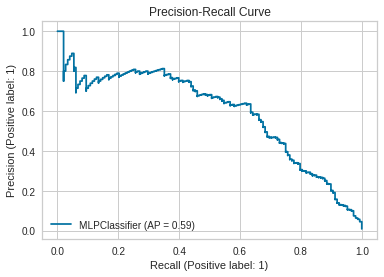

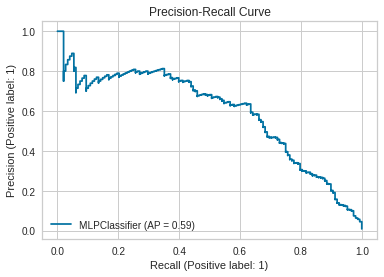

In [ ]:
run = neptune.init_run(
    project='swiatej2/fyp',
    api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjOTQxYjBkZS0zN2Y1LTRhYTQtOGQ1My03YTAxODJkM2E1OWMifQ==',
    name='MLP rerun',
    description='MLP run with updated transition variable',
)

final_scores, final_plots = score_model(final_model, X_train, X_test, y_train, y_test, df_test)

performance_report(final_scores)

run["algorithm"] = 'Multi-Layer Perceptron'
run["params"] = bayes_params
run['features'] = vars_sel
run['metrics/f1'] = final_scores['f1']
run['metrics/hss'] = final_scores['hss']
run['metrics/transition_f1'] = final_scores['transition_f1']
run['metrics/transition_hss'] = final_scores['transition_hss']

# only include this for compatible models
run['metrics/pr_auc'] = final_scores['pr_auc']

# save Precision-Recall curve plot
img_path = os.path.join(path, 'images/mlp_pr_curve.png')
final_plots['pr_plot'].plot()
plt.title("Precision-Recall Curve")
plt.savefig(img_path)

run['plots/pr_curve'].upload(img_path)
run['plots/confusion_matrix'] = npt_utils.create_confusion_matrix_chart(final_model, X_train, X_test, y_train, y_test)

run.stop()

From VM with Bayes optimisation:

pr_auc
Score: 0.5892

f1
Score: 57.59

hss
Score: 0.5728

transition_f1
Score: 28.37

transition_hss
Score: -0.0636

confusion_matrix
Score: [[17361    35]
 [   74    74]]